# Correlating the dark matter density field to ellipticities of Galaxies in  CAMELS Simulation Slices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors 
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py
import hdf5plugin
import treecorr
import time

In [2]:
# snapshot name
snapshot = r'/Volumes/CAMELSDrive/LH310_snapshot_090.hdf5'
# open the snapshot
f = h5py.File(snapshot, 'r')
pos_dm = f['PartType1/Coordinates'][:]/1e3  #positions of dark matter in Mpc/h
pos_s = f['PartType4/Coordinates'][:]/1e3  # star positions in Mpc/h
mass_s = f['PartType4/Masses'][:]*1e10  # star masses in Mpc/h

# close file
f.close()
# catalogue name
catalogue = r'/Volumes/CAMELSDrive/LH310_groups_090.hdf5'
# open the catalogue
f = h5py.File(catalogue, 'r')
# looking to see data in cataloge
# def print_dataset_name(name,g):
#     print(name,'&',g)
# f.visititems(print_dataset_name)
pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10 # total stellar mass of twice the stellare alf-mass radius in Msun/h
nstar_h = f['Group/GroupLenType'][:,4]            # total number of stars in each halo
nstar_sh = f['Subhalo/SubhaloLenType'][:,4]            # total number of stars in each subhalo
n_subhalos = f['Group/GroupNsubs'][:]
# close file
f.close()

In [3]:
print('Total number of subhalos: ',np.sum(n_subhalos))
print("Total number of halos: ", len(n_subhalos))

Total number of subhalos:  20762
Total number of halos:  22280


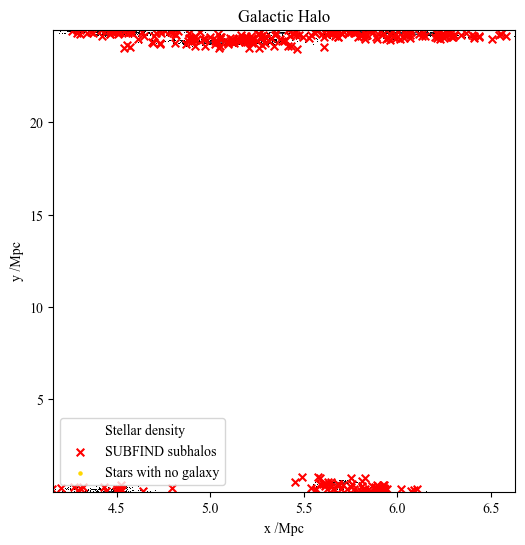

In [5]:
s_first_h = nstar_h[0] # number of stars in first halo
stop = s_first_h
s = n_subhalos[0] # number of subhalos in first halo
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
hist = ax.hist2d(pos_s[:stop, 1], pos_s[:stop, 0], cmap='bone', norm=colors.LogNorm(), bins=500)
sc1 = ax.scatter(pos_s[280824:stop, 1], pos_s[280824:stop, 0], marker='o', s=5, alpha=1.0, c='gold', label='Stars with no galaxy')
sc2 = ax.scatter(pos_sh[:s, 1], pos_sh[:s, 0], marker='x', s=30, alpha=1, c='r', label='SUBFIND subhalos')
ax.set_xlabel('x /Mpc')
ax.set_ylabel('y /Mpc')
ax.set_title('Galactic Halo')
ax.set_box_aspect(1)

# Create a dummy artist for the hist2d plot to add it to the legend
dummy_artist = plt.Line2D([], [], linestyle='-', linewidth=1, color='white', label='Stellar density')
# Combine scatter plots and the dummy artist in the legend
handles = [dummy_artist, sc2, sc1]
labels = [handle.get_label() for handle in handles]
ax.legend(handles=handles, labels=labels)

plt.show()

In [4]:
print("Number of stars: ",len(pos_s))
print("Number of stars in halos: ",np.sum(nstar_h))
print("Number of stars in subhalos: ",np.sum(nstar_sh))

Number of stars:  377530
Number of stars in halos:  376976
Number of stars in subhalos:  376512


#### Assigning every star to a subhalo according to SUBFIND algorithm
If a star does not belong to a subhalo but belongs to a halo, it does not get assigned an index. Stars which do not belong to any halo are at the end of the arrays thus do not get counted.

In [5]:
assigned = np.zeros(len(pos_s), dtype=bool) # Initialize an array to keep track of assigned star particles
# store the assignment of each star particle to a galaxy particle
assignment = -np.ones(len(pos_s), dtype=int)  # The index of the galaxy particle, for unassigned stars assignment =-1

begin_slice = 0
end_slice = nstar_sh[0] # end_slice - begin_silice = number of stars assigned to this subhalo w index subhalo_index
star_count = 0 # star index we are at
subhalo_index = 0   # subhalo index we are at

for i, number_sh in enumerate(n_subhalos): 
    if number_sh!=0: 
        for j in range(number_sh):          # looping through every subhalo in a halo
            
            assigned[begin_slice:end_slice] = True
            assignment[begin_slice:end_slice] = subhalo_index
            
            if nstar_sh[subhalo_index]!=0:
                begin_slice=end_slice
                end_slice = begin_slice + nstar_sh[subhalo_index+1]

            star_count += nstar_sh[subhalo_index]
            
            subhalo_index +=1

                

        old_star_count = star_count
        star_count = np.sum(nstar_h[:i+1])
        #print("unasigned stars: ", star_count - old_star_count)
        begin_slice = star_count   # skipping the stars with no subhalo
        if subhalo_index!=len(nstar_sh):
            end_slice = star_count+nstar_sh[subhalo_index]
    else:
        continue
print("It is",np.sum(n_subhalos)==subhalo_index, "we have counted all subhalos.")

It is True we have counted all subhalos.


Text(0, 0.5, 'subhalo index')

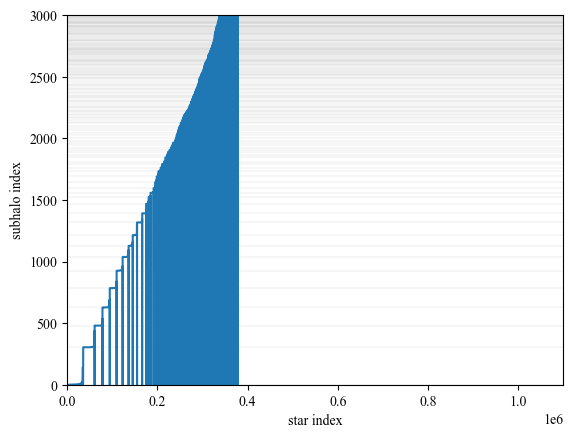

In [8]:
for __ in range(len(n_subhalos)):
    plt.axhline(np.sum(n_subhalos[:__]),c='0.5',linewidth=0.1)
plt.plot(assignment[:])
plt.xlim([0,1.1e6])
plt.ylim([0,3000])
plt.xlabel('star index')
plt.ylabel('subhalo index')

#### Galaxies are subhalos with Mstar > 1e8 Msun

In [6]:
# removing unasigned stars from star index
pos_s1 = pos_s[assigned]
mass_s1 = mass_s[assigned]
assignment1 = assignment[assigned]
# replacing subhalos with low stellar mass with np.nan
pos_g = pos_sh
pos_g[subh_M_R_12<1e9] = np.nan
nstar_g = nstar_sh.astype(float)
nstar_g[subh_M_R_12<1e9] = np.nan
print('Galaxy positions shape: ', pos_g.shape)

high_mass = np.where(subh_M_R_12>1e9)[0]
print(high_mass.shape, "galaxies")

# Create a boolean mask for the stars above the threshold mass
mask = np.isin(assignment1, high_mass)

# Filter out stars in subhalos below the threshold mass
pos_s2 = pos_s1[mask]
mass_s2 = mass_s1[mask]
filtered_assignment1 = assignment1[mask]
print("number of stars remaining:",filtered_assignment1.shape)

Galaxy positions shape:  (20762, 3)
(357,) galaxies
number of stars remaining: (339114,)


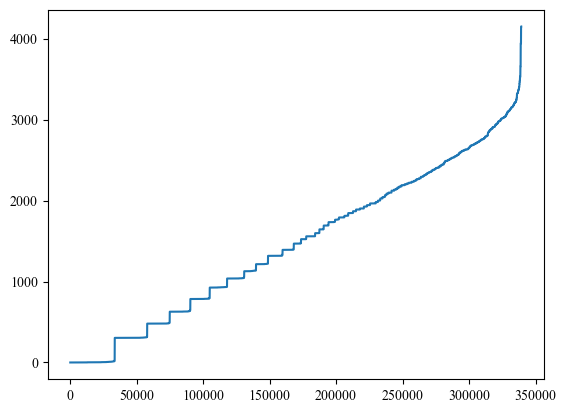

In [10]:
plt.plot(filtered_assignment1)

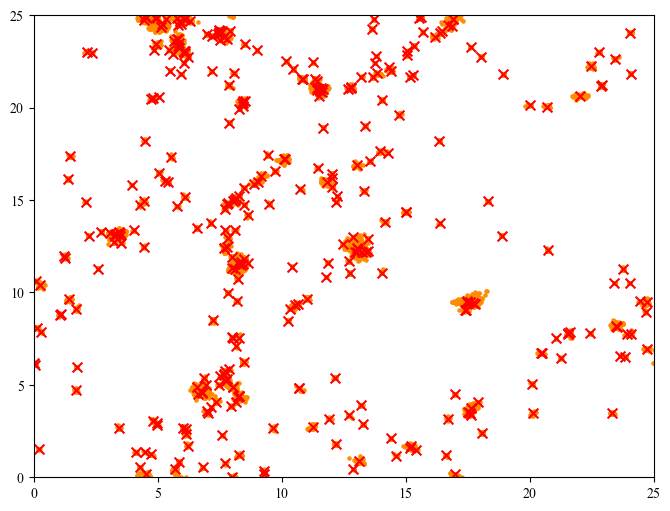

In [7]:
lower_bound = 0
upper_bound = 4976
# Create boolean arrays for the conditions
lower_condition = filtered_assignment1 >= lower_bound
upper_condition = filtered_assignment1 < upper_bound

test = pos_s2[lower_condition & upper_condition]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(test[:,1] , test[:,0], marker='o', s=5, alpha=1.0,c='darkorange')
#ax.hist2d(test[:,1] , test[:,0], cmap='bone', norm=colors.LogNorm(), bins=500)
ax.scatter(pos_g[lower_bound:upper_bound,1] , pos_g[lower_bound:upper_bound,0], marker='x', s=50, alpha=1,c='r')
ax.set_xlim(0,25)
ax.set_ylim(0, 25)
plt.show()

We see due to periodic boundary conditions we have stars assigned to galaxies on the other side of the simulation. To avoid incorrect ellipticity calculations we set a maximum distance from stars to galaxy centre.
#### Calculating Ellipticities of each galaxy cluster

In [8]:
xyz = {'x':[1,2], 'y':[2,0], 'z':[0,1]}
print(xyz['x'])

[1, 2]


In [9]:
def ellipticity(centre, theta, weight, x_y_or_z='z'):
    '''Calculates the ellipticity of a galaxy given its centre and positions of stellar particles
    centre - 3D position of Centre of galaxy
    theta - 3D position of stars
    x_y_or_z: from whcih axis do we want to calculate out 2D ellipticity
    weight - weighting of each star - defined as the density of space around that star'''
    xyz = {'x':[1,2], 'y':[2,0], 'z':[0,1]}
    perp_ax = xyz[x_y_or_z]
    centre = np.array([centre[perp_ax[0]], centre[perp_ax[1]]]).T       # 2D
    theta = np.array([theta[:,perp_ax[0]], theta[:,perp_ax[1]]]).T        # 2D
    separation = theta - centre  #calculating separations of members from cluster centre
    mag = np.linalg.norm(separation, axis=1)
    separation = separation[mag<5] # filtering out stars which are more than 5 Mpc away from galaxy
    weight = weight[mag<5]
    prob = weight/np.max(weight)
    prob = np.array([prob,prob]).T # multiply x and y coord
    separation_scaled = np.multiply(separation, prob)

    Q = (separation.T.dot(separation_scaled))         #'the correlation matrix'
    epsilon = (Q[0, 0] - Q[1, 1] + 2j*Q[0,1])/(Q[0, 0] + Q[1,1] + 2*np.sqrt(np.linalg.det(Q)))				#epsilon

    return epsilon

In [10]:
e_glxys = {}
for axis in ['x','y','z']:
    e_glxys[axis] = 3.0*np.ones(len(pos_g), dtype = 'complex') # set non calaculated values to 3

for axis in ['x','y','z']:
    for i in range(len(pos_g)):
        if ~np.isnan(nstar_g[i]):
            e_glxys[axis][i] = ellipticity(centre=pos_g[i], theta=pos_s2[filtered_assignment1==i],
                                           weight=mass_s2[filtered_assignment1==i], x_y_or_z=axis)

    
phis = {}
axis_ratio = {}
for axis in ['x','y','z']:
    phis[axis] = np.angle(e_glxys[axis])/2						#angle of ellipse in degrees 
    axis_ratio[axis] = (1 - np.absolute(e_glxys[axis]))/(1 + np.absolute(e_glxys[axis]))

In [11]:
# sifting noncalculated values 
pos_g2 = pos_g[~np.isnan(pos_g).any(axis=1)] # sifting 
axis_ratio1 = {}
phis1 = {}
for axis, ratio_array in axis_ratio.items():
    filtered_values = ratio_array[ratio_array != -0.5]
    axis_ratio1[axis] = filtered_values
for axis, angle_array in phis.items():
    filtered_values = angle_array[angle_array != 0.]
    phis1[axis] = filtered_values
    e_glxys[axis] = e_glxys[axis][e_glxys[axis]!=3]
    print(f"Old Shape of angles and ratios for axis '{axis}': {angle_array.shape}")

print("positions of galaxies with high mass shape:",pos_g2.shape)
for axis, angle_array in phis1.items():
    print(f"New Shape of angles and ratios for axis '{axis}': {angle_array.shape}")

all_q = np.concatenate([ratio_array for ratio_array in axis_ratio1.values()])
all_e = np.concatenate([e_array for e_array in e_glxys.values()]) # distributions of ellipticities
print("Axis ratio of most elliptical galaxies:", np.sort(all_q)[:20])

Old Shape of angles and ratios for axis 'x': (20762,)
Old Shape of angles and ratios for axis 'y': (20762,)
Old Shape of angles and ratios for axis 'z': (20762,)
positions of galaxies with high mass shape: (357, 3)
New Shape of angles and ratios for axis 'x': (357,)
New Shape of angles and ratios for axis 'y': (357,)
New Shape of angles and ratios for axis 'z': (357,)
Axis ratio of most elliptical galaxies: [0.20158571 0.25556418 0.25875728 0.28369362 0.29083452 0.29334478
 0.30677387 0.30773886 0.32001661 0.32254861 0.33205164 0.3514729
 0.35168369 0.35225639 0.35556029 0.35719366 0.35774592 0.3593763
 0.36166195 0.36835131]


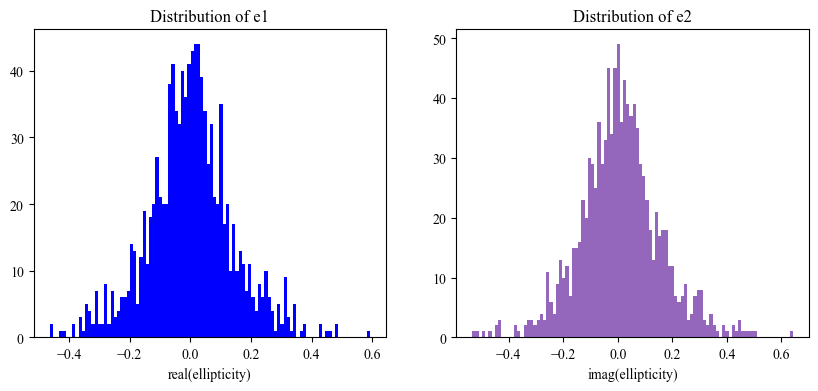

In [12]:
fig, ax = plt.subplots(1, 2,figsize=(10, 4))
ax[0].hist(all_e.real,bins=100,label='e1',color='blue')
ax[0].set_title('Distribution of e1')
ax[0].set_xlabel('real(ellipticity)')
ax[1].hist(all_e.imag,bins=100,label='e2',color='tab:purple')
ax[1].set_title('Distribution of e2')
ax[1].set_xlabel('imag(ellipticity)')
plt.show()

In [13]:
def stick_plot(ax, x, y, ellipticity, phi, bar_scaling=1, plot_index=None):
    '''Imput the positions of galaxies, magnitudee of the complex ellipticity '''
    ellipticity = ellipticity  * bar_scaling # making more elliptical galaxies loger bars
    del_y = ellipticity*np.sin(phi)
    del_x = ellipticity*np.cos(phi)
    # positions of ends of bar
    barx = np.array([x+del_x,x-del_x])
    bary = np.array([y+del_y,y-del_y])
    bars = np.array([barx,bary])
    
    #fig, ax = plt.subplots(figsize=(6,6))
    for i in range(len(ellipticity)):
        ax.plot(bars[0,:,i],bars[1,:,i],color='#EF2E72') 
        #ax.set_xticks([])
        #ax.set_yticks([])
        #ax.set_title('Showing Ellipticities of Galaxies')
        ax.set_box_aspect(1)

In [14]:
def stick_plot(ax, x, y, ellipticity, phi, scaling=1, eccentricity=1, plot_index=None):
    """Plot galaxies as ellipses instead of bars.
    Semi-major = (1 + |ε|/2) * scaling
    Semi-minor = (1 - |ε|/2) * bar_scaling
    phi is the orientation in radians.
    """
    from matplotlib.patches import Ellipse
    global example_ell

    x = np.asarray(x)
    y = np.asarray(y)
    e = np.asarray(ellipticity)* eccentricity
    phi = np.asarray(phi)

    # Ensure shapes match
    N = min(len(x), len(y), len(e), len(phi))

    for i in range(N):
        ei = np.abs(e[i])
        a = (1.0 + ei / 2.0) * scaling   # semi-major
        b = (1.0 - ei / 2.0) * scaling  # semi-minor
        # convert phi (radians) to degrees for Ellipse angle
        angle_deg = np.degrees(phi[i])
        ell = Ellipse((x[i], y[i]), width=2*a, height=2*b,
                      angle=angle_deg, edgecolor='#EF2E72',
                      facecolor='none', linewidth=0.8, alpha=0.9, zorder=4)
        ax.add_patch(ell)
    
    ax.set_box_aspect(1)

average q value of elliptical galaxies in x axis:  0.7221071479799904
average q value of elliptical galaxies in y axis:  0.7269931109976416
average q value of elliptical galaxies in z axis:  0.7195543409912587


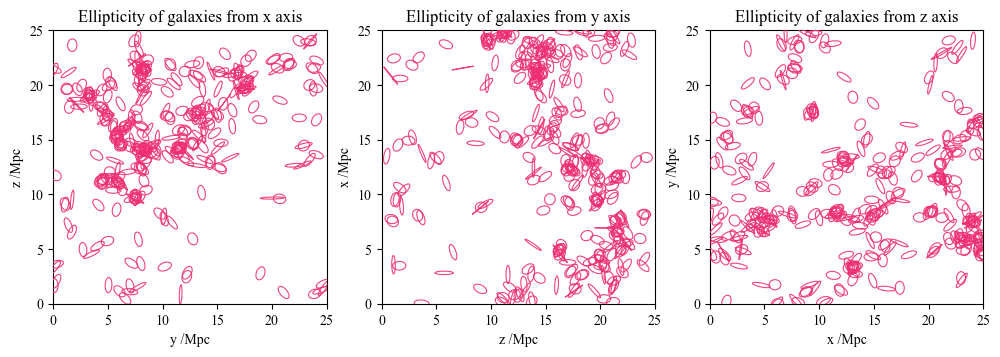

In [15]:
xyz = [['x',1,2],['y',2,0],['z',0,1]]
fig, ax = plt.subplots(1, 3,figsize=(12, 4))
for x_y_or_z in range(3):
    _ax_ = xyz[x_y_or_z][0] # which axis is perpendicular to the slice
    h = xyz[x_y_or_z][1] # horizontal axis
    v = xyz[x_y_or_z][2] # vertical axis

    #ax = fig.add_subplot(1,3,x_y_or_z+1)
    ax[x_y_or_z].set_xlabel(f'{xyz[h][0]} /Mpc')
    ax[x_y_or_z].set_ylabel(f'{xyz[v][0]} /Mpc')
    ax[x_y_or_z].set_title(f"Ellipticity of galaxies from {_ax_} axis")
    stick_plot(ax[x_y_or_z], pos_g2[:,h], pos_g2[:,v], np.absolute(e_glxys[_ax_]), phis1[_ax_], scaling=0.5,eccentricity=4)
    ax[x_y_or_z].set_xlim([0,25])
    ax[x_y_or_z].set_ylim([0,25])
    print(f"average q value of elliptical galaxies in {_ax_} axis: ", np.mean(axis_ratio1[_ax_]))
plt.show()

#### Slicing Galaxies, Stars and Dark Matter along x, y and z

In [16]:
def slicer(array, num_slices=15, ell_dict=None, ell=False):
    '''Slices positions of particles in a box perpendicular to the axes x, y and z.
    array has shape (N,3)
    (If ell=True we also slice the 2D ellipticity of the particle with index corresponding to index in position array)
    Returns a dictionary (or two) with each section containing positions of that slice (and the correlsponding 
    ellipticities for that axis)'''
    box_length = 25.0  # Length of the 3D box
    pos_index = 0
    slice_size = box_length / num_slices  # Size of each slice along the z-axis
    # Initialize an empty dictionary to store the particle positions for each slice
    sliced_positions = {}
    sliced_ell = {}
    
    # Initialize the dictionary with empty arrays for each slice along each axis
    for axis in ['x', 'y', 'z']:
        sliced_positions[axis] = {i: [] for i in range(num_slices)}
        if ell == True:
            sliced_ell[axis] = {i: [] for i in range(num_slices)}   
    # Initialize the dictionary with empty arrays for each slice
#     for i in range(num_slices):
#         sliced_positions[i] = []
#         if mass == True:
#             sliced_masses[i] = []
    # Iterate over each particle position
    
    # Iterate over each particle position
    for position in array:
        # Calculate the index of the slice based on the x, y, and z coordinates
        x_slice_index = int(position[0] // slice_size)
        y_slice_index = int(position[1] // slice_size)
        z_slice_index = int(position[2] // slice_size)

        # Append the position to the corresponding slice's array for each axis
        sliced_positions['x'][x_slice_index].append(position)
        sliced_positions['y'][y_slice_index].append(position)
        sliced_positions['z'][z_slice_index].append(position)    
        
        if ell==True:
            sliced_ell['x'][x_slice_index].append(ell_dict['x'][pos_index])
            sliced_ell['y'][y_slice_index].append(ell_dict['y'][pos_index])
            sliced_ell['z'][z_slice_index].append(ell_dict['z'][pos_index])
            pos_index+=1
        
            
#     for position in array:
#         # Calculate the index of the slice based on the z-coordinate
#         slice_index = int(position[2] // slice_size)

#         # Append the position to the corresponding slice's array
#         sliced_positions[slice_index].append(position)
#         if mass==True:
#             sliced_masses[slice_index].append(mass_array[pos_index])
#             pos_index +=1

    # Convert the lists to numpy arrays
    for axis in ['x', 'y', 'z']:
        for slice_index in sliced_positions[axis]:
            sliced_positions[axis][slice_index] = np.array(sliced_positions[axis][slice_index])
            if ell==True: 
                sliced_ell[axis][slice_index] = np.array(sliced_ell[axis][slice_index])


#     # Convert the lists to numpy arrays
#     for slice_index in sliced_positions:
#         sliced_positions[slice_index] = np.array(sliced_positions[slice_index])
#         if mass==True: 
#             sliced_masses[slice_index] = np.array(sliced_masses[slice_index])

    # Print the positions for each slice along each axis
    for axis in ['x', 'y', 'z']:
        print(f"Slices along {axis}-axis:")
        for slice_index in sliced_positions[axis]:
            print(f"Slice {slice_index}:", sliced_positions[axis][slice_index].shape)

#     # Print the positions for each slice
#     for slice_index in sliced_positions:
#         print(f"Slice {slice_index} shape: ", sliced_positions[slice_index].shape)
    if ell==True:
        return sliced_positions, sliced_ell
    else:
        return sliced_positions

In [17]:
print("STARS")
sliced_s= slicer(pos_s2, num_slices=15) # slicing stars
print("GALAXIES")
sliced_g, sliced_ell = slicer(pos_g2, num_slices=15, ell_dict=e_glxys, ell=True) # slicing galaxies
#sliced_g, sliced_phi = slicer(pos_g2, num_slices=15, ell_dict=phis1, ell=True) # slicing galaxies
print("DARK MATTER")
sliced_dm = slicer(pos_dm, num_slices=15) # slicing dark matter

STARS
Slices along x-axis:
Slice 0: (12399, 3)
Slice 1: (15094, 3)
Slice 2: (33263, 3)
Slice 3: (9563, 3)
Slice 4: (11683, 3)
Slice 5: (29224, 3)
Slice 6: (25840, 3)
Slice 7: (46522, 3)
Slice 8: (14264, 3)
Slice 9: (13532, 3)
Slice 10: (14055, 3)
Slice 11: (1625, 3)
Slice 12: (26725, 3)
Slice 13: (21534, 3)
Slice 14: (63791, 3)
Slices along y-axis:
Slice 0: (11800, 3)
Slice 1: (14547, 3)
Slice 2: (24050, 3)
Slice 3: (50333, 3)
Slice 4: (74665, 3)
Slice 5: (13447, 3)
Slice 6: (29759, 3)
Slice 7: (39612, 3)
Slice 8: (11587, 3)
Slice 9: (9408, 3)
Slice 10: (33619, 3)
Slice 11: (660, 3)
Slice 12: (6247, 3)
Slice 13: (6704, 3)
Slice 14: (12676, 3)
Slices along z-axis:
Slice 0: (6431, 3)
Slice 1: (6439, 3)
Slice 2: (2893, 3)
Slice 3: (4136, 3)
Slice 4: (7753, 3)
Slice 5: (12467, 3)
Slice 6: (25877, 3)
Slice 7: (26778, 3)
Slice 8: (47549, 3)
Slice 9: (35964, 3)
Slice 10: (45001, 3)
Slice 11: (46385, 3)
Slice 12: (54695, 3)
Slice 13: (10773, 3)
Slice 14: (5973, 3)
GALAXIES
Slices along x-axis:

In [18]:
sliced_phi = {}
for axis in ['x', 'y', 'z']:
    sliced_phi[axis] = {i: [] for i in range(15)}
for axis in ['x', 'y', 'z']:
    for slice_, ell_array in sliced_ell[axis].items():
        sliced_phi[axis][slice_] = np.angle(ell_array)/2

### Correlation for 1 slice along 1 axis

Number of galaxies in this slice: (71, 3)


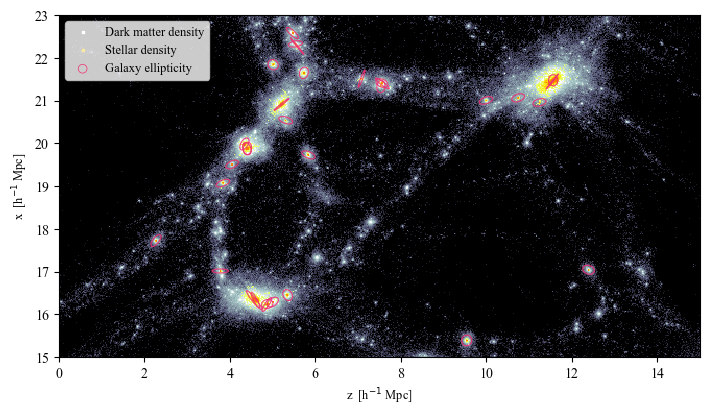

In [25]:
x_y_or_z = 1
_slice_ =4
xyz = [['x',1,2],['y',2,0],['z',0,1]]
_ax_ = xyz[x_y_or_z][0] # which axis is perpendicular to the slice
h = xyz[x_y_or_z][1] # horizontal axis
v = xyz[x_y_or_z][2] # vertical axis
print("Number of galaxies in this slice:", sliced_g[_ax_][_slice_].shape)
fig = plt.figure(figsize=(25/3,4.44))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor('0')
ax.set_xlabel(f'{xyz[h][0]}  '+ r'[h$^{-1}$ Mpc]',size=9)
ax.set_ylabel(f'{xyz[v][0]}  '+ r'[h$^{-1}$ Mpc]',size=9)
# ax.set_title(f'Ellipticities of Galaxies on Dark Matter from {_ax_} axis slice {_slice_}')
#ax.scatter(sliced_dm[_ax_][_slice_][:,1] , sliced_dm[_ax_][_slice_][:,0], marker='o', s=0.0005, alpha=0.5,c='k')
bins = 1024
dmd = ax.hist2d(sliced_dm[_ax_][_slice_][:,v] , sliced_dm[_ax_][_slice_][:,h], cmap='bone', norm=colors.LogNorm(vmin=1, vmax=200), bins=bins, label='dark matter density')
# im= ax.scatter(sliced_s[_ax_][_slice_][:,h] , sliced_s[_ax_][_slice_][:,v], c='gold',
#                 marker='o', s=0.5, alpha=1)
import numpy.ma as ma
x = sliced_s[_ax_][_slice_][:,v]
y = sliced_s[_ax_][_slice_][:,h]
H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0,25],[0,25]])
Hm = ma.masked_where(H == 0, H)                # mask empty bins
cmap_black_yellow = LinearSegmentedColormap.from_list('black_yellow', ['black', 'gold'])
cmap_black_yellow.set_bad((0, 0, 0, 0))        # masked cells -> transparent
stel = ax.pcolormesh(xedges, yedges, Hm.T, cmap='Wistia',
              norm=colors.Normalize(vmin=1,vmax=25), shading='auto', zorder=3, label='stellar density')
ax.set_xlim([0,15])
ax.set_ylim([15,23])
stick_plot(ax,sliced_g[_ax_][_slice_][:,v], sliced_g[_ax_][_slice_][:,h], np.absolute(sliced_ell[_ax_][_slice_]), 
           sliced_phi[_ax_][_slice_], scaling=0.12, eccentricity=5)
# Create legend manually
legend_elements = [
    ax.scatter([], [], s=1.5, marker='s',color='1', label='Dark matter density'),
    ax.scatter([], [], s=1.5, marker='s', color='#fbe99f', label='Stellar density'),
    ax.scatter([], [], linewidths=0.5, s=40, facecolors='none', edgecolors='#EF2E72', label='Galaxy ellipticity'),

]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

#ax.scatter(sliced_g[_ax_][_slice_][:,h], sliced_g[_ax_][_slice_][:,v], marker='x', s=50, alpha=1,c='r')
ax.set_box_aspect(8/15)
plt.savefig(f'/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/sim_visual/310ellipticities_on_dm_{_ax_}_slice_{_slice_}_3.png', dpi=600)
plt.show()

### Exporting/Saving Dictionaries 

In [14]:
import pickle

# Save dictionaries to a file using pickle
with open('C:\CAMELS DATA/dictionary_data_LH643.pkl', 'wb') as f:
    pickle.dump({
        'posg': pos_g2,
        'ellipticities': e_glxys,
        'dm_den': pos_dm
    }, f)

In [22]:
import pickle

# Save dictionaries to a file using pickle
with open('C:\CAMELS DATA/sliced_dictionary_data_LH643.pkl', 'wb') as f:
    pickle.dump({
        'sliced_s': sliced_s,
        'sliced_g': sliced_g,
        'sliced_ell': sliced_ell,
        'sliced_dm': sliced_dm
    }, f)